<a href="https://colab.research.google.com/github/aniketsharma00411/ML-Zoomcamp/blob/main/Session%204/Session%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/homework.md

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-01 17:38:28--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.06s   

2021-10-01 17:38:28 (3.05 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   home       4454 non-null   object
 2   time       4454 non-null   int64 
 3   age        4454 non-null   int64 
 4   marital    4454 non-null   object
 5   records    4454 non-null   object
 6   job        4454 non-null   object
 7   expenses   4454 non-null   int64 
 8   income     4454 non-null   int64 
 9   assets     4454 non-null   int64 
 10  debt       4454 non-null   int64 
 11  amount     4454 non-null   int64 
 12  price      4454 non-null   int64 
 13  default    4454 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 487.3+ KB


In [9]:
categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
auc_scores = {}
for feature in numerical:
    score = roc_auc_score(df_train.default, df_train[feature])
    if score < 0.5:
        score = roc_auc_score(df_train.default, -df_train[feature])
    auc_scores[feature] = score

auc_scores

{'age': 0.5732933272499939,
 'amount': 0.5910773431595518,
 'assets': 0.6486042567122802,
 'debt': 0.5047829675783548,
 'expenses': 0.5009184217217011,
 'income': 0.682006666132633,
 'price': 0.5043329862114843,
 'seniority': 0.7093778624491943,
 'time': 0.5608662489595051}

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

`seniority` has the highest AUC.

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [12]:
X_full_train = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
X_train = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
X_val = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home']]
X_test = df_test[['seniority', 'income', 'assets', 'records', 'job', 'home']]

y_full_train = df_full_train['default']
y_train = df_train['default']
y_val = df_val['default']
y_test = df_test['default']

In [13]:
X_train_dict = X_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train_one_hot = dv.fit_transform(X_train_dict)

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train_one_hot, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [15]:
round(roc_auc_score(y_val, model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1]), 3)

0.812

Model AUC on validation dataset is **0.812**.

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [16]:
thresholds = np.arange(0, 1, step=0.01)

precision = []
recall = []
for t in thresholds:
    precision.append(precision_score(y_val, (model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1] >= t)))
    recall.append(recall_score(y_val, (model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1] >= t)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

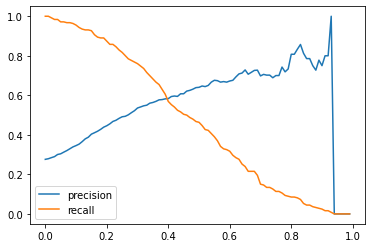

In [17]:
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.legend()

plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

Precision and recall curves intersect at **0.4** threshold.

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [18]:
P = np.array(precision)
R = np.array(recall)

f1 = 2*(P*R)/(P+R)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [19]:
thresholds[list(f1).index(max(f1))]

0.3

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

F1 is maximal at **0.3** threshold.

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_index, val_index in kf.split(X_full_train):
    X_train = X_full_train.iloc[train_index]
    y_train = y_full_train.iloc[train_index]
    X_val = X_full_train.iloc[val_index]
    y_val = y_full_train.iloc[val_index]

    X_train_dict = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)

    X_train_one_hot = dv.fit_transform(X_train_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train_one_hot, y_train)

    score = roc_auc_score(y_val, model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1])
    scores.append(score)

scores

[0.8256212256212256,
 0.8254077031563474,
 0.789298525308888,
 0.8153421373265731,
 0.8054696294614563]

In [21]:
np.std(scores)

0.013669069470482898

How large is standard deviation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

Standard deviation of the scores across different folds is **0.014**.

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [22]:
mean_scores = []
std_scores = []
for C in [0.01, 0.1, 1, 10]:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_index, val_index in kf.split(X_full_train):
        X_train = X_full_train.iloc[train_index]
        y_train = y_full_train.iloc[train_index]
        X_val = X_full_train.iloc[val_index]
        y_val = y_full_train.iloc[val_index]

        X_train_dict = X_train.to_dict(orient='records')

        dv = DictVectorizer(sparse=False)

        X_train_one_hot = dv.fit_transform(X_train_dict)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

        model.fit(X_train_one_hot, y_train)

        score = roc_auc_score(y_val, model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1])
        scores.append(score)
        
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

mean_scores, std_scores

([0.8076876665463588,
  0.8129017360952779,
  0.812227844174898,
  0.8141433397756099],
 [0.011832148394108436,
  0.013740829347711075,
  0.013669069470482898,
  0.014614166612648758])

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

**C=10** leads to the best mean score.